In [1]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
import os

load_dotenv()
def set_env_vars(var):
    os.environ[var] = os.getenv(var)


vars = ["OPENAI_API_KEY", "LANGCHAIN_API_KEY", "LANGCHAIN_TRACING_V2", "LANGCHAIN_ENDPOINT", "LANGCHAIN_PROJECT", "TAVILY_API_KEY"]

for var in vars:
    set_env_vars(var)

llm = ChatOpenAI(model="gpt-4o-mini")


In [3]:
import uuid 
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()

In [4]:
#Namespace 
user_id = "1"
namespace_for_memory = (user_id, "memories")

#key
key = str(uuid.uuid4())

#value
value = {'food_preferences': 'I like pizza'}

#set the value
in_memory_store.put(namespace_for_memory, key, value)


In [5]:
memories = in_memory_store.search(namespace_for_memory)
type(memories)

list

In [12]:
memories[0].dict()

{'namespace': ['1', 'memories'],
 'key': 'b2789a42-ee6c-4b3e-8c66-58e17e24e656',
 'value': {'food_preferences': 'I like pizza'},
 'created_at': '2025-01-06T20:30:06.108600+00:00',
 'updated_at': '2025-01-06T20:30:06.108603+00:00',
 'score': None}

In [13]:
print(memories[0].key)
print(memories[0].value)



b2789a42-ee6c-4b3e-8c66-58e17e24e656
{'food_preferences': 'I like pizza'}


In [21]:
#Get memory by namespace key

memory = in_memory_store.get(namespace_for_memory, key)

memory



Item(namespace=['1', 'memories'], key='b2789a42-ee6c-4b3e-8c66-58e17e24e656', value={'food_preferences': 'I like pizza'}, created_at='2025-01-06T20:30:06.108600+00:00', updated_at='2025-01-06T20:30:06.108603+00:00')

In [39]:
from IPython.display import Image, display

from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore
from langgraph.store.base import BaseStore
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables import RunnableConfig

class MemoryChatState(MessagesState):
    """ Add a new field to the state to store the memory."""
    memory: str = ""

def call_model(state: MemoryChatState, config: RunnableConfig, store:BaseStore):
    """ Load memory from the store and use it to personalize the chatbot's response."""

    print("-------CALL MODEL NODE------")

    user_id = config["configurable"]["user_id"]
    namespace = (user_id, "memory")
    key = "user_memory"
    existing_memory = store.get(namespace, key)

    if existing_memory:
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."

    print(f"Existing memory: {existing_memory_content}")

    MODEL_SYSTEM_MESSAGE = """
    You are an helpful assistant with memory thta provides information about the user.
    If you have memory for this user, use it to personalize your response.
    Here is the memory (it may be empty): {memory}
    """

    system_message = MODEL_SYSTEM_MESSAGE.format(memory=existing_memory_content)
    state["memory"] = existing_memory_content

    response = llm.invoke([SystemMessage(content=system_message)] +  state["messages"])
    print(f"Response: {response}")
    print("--------------------------------")
    print(f"State: {state}")
    print("-------END CALL MODEL NODE------")
    return {"messages": [response]}


def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """ Relfect on the chat history and save it to the memory store."""

    print("-------WRITE MEMORY NODE------")

    user_id = config["configurable"]["user_id"]
    name_space = (user_id, "memory")
    key = "user_memory"

    existing_memory = store.get(name_space, key)

    if existing_memory:
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."

    CREATE_MEMORY_INSTRUCTION = """
    You are colecting information about the user to personalize your responses.

    CURRENT USER INFORMATION:
    {memory}

    INSTRUCTIONS:
    1. Review the chat history below carefully.
    2 Identify new information about the user such as:
        - Personal details (name, age, location, etc)
        - Preferences(likes, dislikes, etc)
        - Hobbies and interests
        - Past experiences
        - Goald or future plans
    3. Merge any new information with existing memory.
    4. Format the memory as a clear bullet list.
    5. If new information conflicts with existing memory, keep the most recent version.


    Remeber: Only include factual information directly stated by the user. Do not make any assumptions or inferences.

    Based on the chat history below, please update the user information:
    """

    system_message = CREATE_MEMORY_INSTRUCTION.format(memory=existing_memory_content)

    new_memory = llm.invoke([SystemMessage(content=system_message)] + state["messages"])

    store.put(name_space, key, {'memory': new_memory.content})

    print(f"New memory: {new_memory.content}")
    print("--------------------------------")
    print(f"State: {state}")
    print("-------END WRITE MEMORY NODE------")

    return {"memory": [new_memory]}



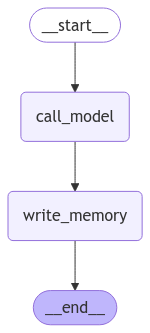

In [40]:
builder = StateGraph(MemoryChatState)

builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)

builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

within_thread_memory = MemorySaver()
across_thread_memory = InMemoryStore()

graph = builder.compile(checkpointer = within_thread_memory, store = across_thread_memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [41]:
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Hithik")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Hithik
-------CALL MODEL NODE------
Existing memory: No existing memory found.
Response: content="Hi Hithik! It's nice to meet you. How can I assist you today?" additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 69, 'total_tokens': 88, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'stop', 'logprobs': None} id='run-fce247e8-12de-4d8c-9fca-e5afe2955f2d-0' usage_metadata={'input_tokens': 69, 'output_tokens': 19, 'total_tokens': 88, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
--------------------------------
State: {'me

In [44]:
input_messages = [HumanMessage(content="I like to play bike around in San Francisco")]

for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to play bike around in San Francisco
-------CALL MODEL NODE------
Existing memory: **User Information:**
- Name: Hithik
Response: content='That sounds like a lot of fun, Hithik! San Francisco has some great spots for biking. Do you have any favorite routes or places you like to ride?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 111, 'total_tokens': 146, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None} id='run-dc4acfba-b53b-47f6-9023-9435c0710f18-0' usage_metadata={'input_tokens': 111, 'output_tokens': 35, 'total_tokens': 146, 'input_token_details': {'audio'

In [45]:
user_id = "1"
namespace = (user_id, "memory")
key = "user_memory"

memory = across_thread_memory.get(namespace, key)
memory.dict()



{'namespace': ['1', 'memory'],
 'key': 'user_memory',
 'value': {'memory': '**User Information:**\n- Name: Hithik\n- Likes: Playing bike around in San Francisco\n'},
 'created_at': '2025-01-07T01:23:59.483379+00:00',
 'updated_at': '2025-01-07T01:23:59.483380+00:00'}

In [46]:
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

input_messages = [HumanMessage(content="Hey! Where do you recommend I go for biking?")]

for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hey! Where do you recommend I go for biking?
-------CALL MODEL NODE------
Existing memory: **User Information:**
- Name: Hithik
- Likes: Playing bike around in San Francisco

Response: content="Hey Hithik! Since you enjoy biking around San Francisco, I recommend checking out the Golden Gate Park. It has some beautiful trails and scenic views. Another great spot is the Embarcadero, where you can bike along the waterfront and enjoy views of the bay. If you're up for a challenge, consider riding over the Golden Gate Bridge to Marin Headlands for stunning vistas. Enjoy your ride!" additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 89, 'total_tokens': 171, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_toke

In [47]:
input_messages = [HumanMessage(content="Great! are there any bakeries around that I can check out? I like croissants after biking.")]

for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()


================================ Human Message =================================

Great! are there any bakeries around that I can check out? I like croissants after biking.
-------CALL MODEL NODE------
Existing memory: **User Information:**
- Name: Hithik
- Likes: Playing bike around in San Francisco
- Hobbies and interests: Biking, exploring scenic locations
Response: content='Absolutely! After your biking adventures, you can treat yourself to some delicious croissants at a few great bakeries in San Francisco:\n\n1. **Tartine Bakery** - Famous for its flaky pastries, Tartine offers some of the best croissants in the city. It’s a perfect spot to relax after a bike ride.\n\n2. **B Patisserie** - Known for its incredible French pastries, their croissants are a must-try.\n\n3. **Mr. Holmes Bakehouse** - They have a wonderful selection of pastries, including croissants, and the atmosphere is fun and vibrant.\n\n4. **La Boulangerie de San Francisco** - A local favorite for classic French pa